# Notebook: Preprocesamiento de Datos de Beam (CHARM)

En esta sección vamos a leer, limpiar y concatenar los archivos CSV del beam para obtener un único DataFrame con:
- **Time**: timestamp (`datetime64[ns]`)
- **TID**: dosis acumulada (Gy)
- **HEH**: conteo acumulado de hadrones
- **N1MeV**: conteo acumulado de neutrones > 1 MeV

Nos interesa extraer:
- La columna `Time` (convertirla a `datetime64[ns]`).
- `TID_RAW1` renombrada como `TID`.
- `HEH` (ya en conteo acumulado).
- `N1MeV_RAW0` renombrada como `N1MeV`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from lib.beam import load_and_check_run

In [2]:


# 1) Buscar todos los archivos CSV de beam
beam_paths = glob.glob(os.path.join("..", "0_raw", "Campaign3", "beam", "merged_data.csv"), recursive=True)
if not beam_paths:
    raise FileNotFoundError("No se encontraron archivos '*.csv' en las rutas esperadas.")

beam_paths

['..\\0_raw\\Campaign3\\beam\\merged_data.csv']

-------------------------------------------------------------
==== ..\0_raw\Campaign3\beam\merged_data.csv ====


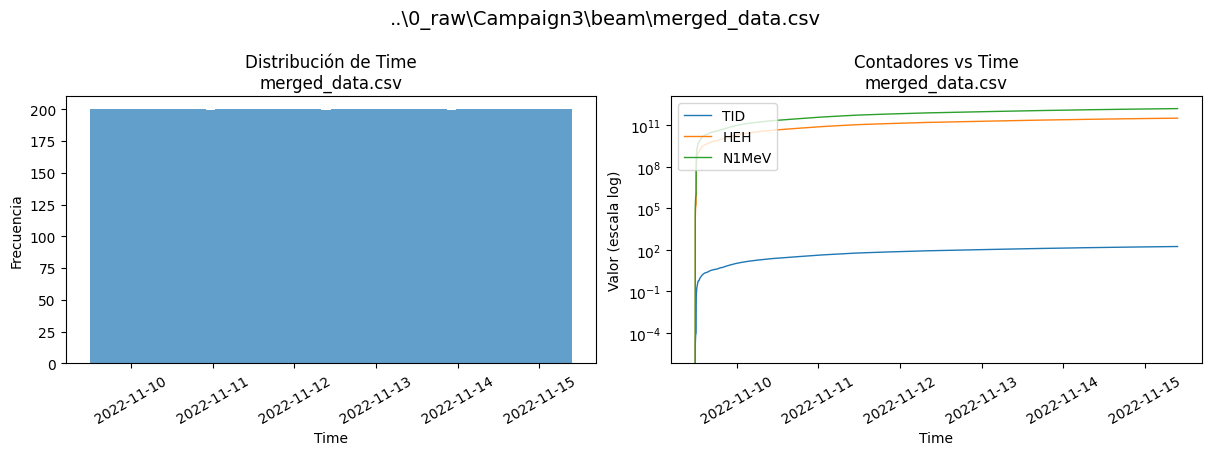

Cargado: ..\0_raw\Campaign3\beam\merged_data.csv  (run_group=run_1, 9997 filas)
-------------------------------------------------------------
#========================= Comprobación de time stamps espaciados ===========================#

=== Run 1 (1) ===
Duplicados en Time: 0

Intervalos entre lecturas (segundos) — estadísticos:
count    9.996000e+03
mean     5.105491e+01
std      1.581476e-07
min      5.105491e+01
1%       5.105491e+01
5%       5.105491e+01
10%      5.105491e+01
50%      5.105491e+01
90%      5.105491e+01
95%      5.105491e+01
99%      5.105491e+01
max      5.105491e+01
Name: Time, dtype: float64

No se detectaron saltos significativos (gaps > median + 5·IQR).


In [3]:
# =======================================================#
# Leer todos los runs, chequear y almacenar en lista
plot_variables = True
dfs_runs = []
print("-------------------------------------------------------------")
for idx, path in enumerate(beam_paths, start=1):
    # try:
    #     df_run = load_and_check_run(path, idx, plot=plot_variables)
    #     dfs_runs.append(df_run)
    #     print(f"Cargado y verificado: {path}  (run_group=run_{idx}, {len(df_run)} filas)")
    # except Exception as e:
    #     print(f"Posible error en {path}: {e}")
    #     # lo almacenaré de todos modos, pues aun no he conversado esto de monotonia
    #     # podría ser producto de ruido y is_monotonic_inreasing sea demasiado simple

    # codigo temporal, importando todo:
    print(f"==== {path} ====")
    df_run = load_and_check_run(path, idx, plot=plot_variables, title=path)
    print(f"Cargado: {path}  (run_group=run_{idx}, {len(df_run)} filas)")
    dfs_runs.append(df_run)
    print("-------------------------------------------------------------")
 
print("#========================= Comprobación de time stamps espaciados ===========================#")


# ========================================================#
# Comprobación de time stamps espaciados

for idx, df_run in enumerate(dfs_runs, start=1):
    run_id = df_run["run_group"].iloc[0]
    times = df_run["Time"]

    print(f"\n=== Run {idx} ({run_id}) ===")
    
    # 1) Detectar duplicados exactos en el timestamp
    n_duplicados = times.duplicated().sum()
    print(f"Duplicados en Time: {n_duplicados}")
    
    # 2) Calcular diffs entre timestamps consecutivos (en segundos)
    diffs = times.diff().dt.total_seconds().dropna()
    
    # Estadísticos básicos de diffs
    desc_diffs = diffs.describe(percentiles=[0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99])
    print("\nIntervalos entre lecturas (segundos) — estadísticos:")
    print(desc_diffs)
    
    # 3) Identificar saltos grandes: diffs > median + 5·IQR (como heurística)
    median = diffs.median()
    iqr = diffs.quantile(0.75) - diffs.quantile(0.25)
    umbral_gap = median + 5 * iqr
    gaps = diffs[diffs > umbral_gap]
    
    if len(gaps) == 0:
        print("\nNo se detectaron saltos significativos (gaps > median + 5·IQR).")
    else:
        print(f"\nSaltos detectados (diff > {umbral_gap:.2f} s): {len(gaps)} ocurrencias")
        # Mostrar los primeros 5 saltos
        for t, delta in gaps.head(5).items():
            print(f"---> Gap en {t} → intervalo = {delta:.2f} s")
        # Mostrar los 5 saltos más grandes
        top5 = gaps.sort_values(ascending=False).head(5)
        print("\nCinco saltos más grandes:")
        for t, delta in top5.items():
            print(f"---> Gap en {t} → intervalo = {delta:.2f} s")

# ========================================================#



In [4]:
df_run.head()

,Time,TID,HEH,N1MeV,run_group
0,2022-11-09 11:50:54.109810944,0.000000,0.000000,0.000000,1
1,2022-11-09 11:51:45.164716544,0.000005,8850.860477,43362.535028,1
2,2022-11-09 11:52:36.219621888,0.000006,11777.622403,57701.459126,1
3,2022-11-09 11:53:27.274527488,0.000014,26728.113026,130947.577404,1
4,2022-11-09 11:54:18.329433088,0.000024,45600.538023,223408.213538,1


## Creación de la Pipeline para BEAM

Se consigue un $dt$ para entender la diferencia entre datos.

Luego con las variables de diferencia se consigue el dose rate

In [1]:
def beam_pipeline(df, epsilon=1e-7,debug=False):
    """
    df_run: a beam dataframe with columns Time, TID, HEH, N1MeV
    epsilon [Gy/s], typical ambient value its 1e-7 [Gy/s]
    """
    # df con columnas Time, TID, HEH, N1MeV
    df = df.sort_values('Time')
    df['dt']        = df['Time'].diff().dt.total_seconds()
    df['dTID']      = df['TID'].diff()
    df['dHEH']      = df['HEH'].diff()
    df['dN1MeV']    = df['N1MeV'].diff()
    df['TID_dose_rate'] = df['dTID'] / df['dt']
    df['N1MeV_dose_rate'] = df['dN1MeV'] / df['dt']
    df['HEH_dose_rate'] = df['dHEH'] / df['dt']
    
    df['beam_on'] = df['TID_dose_rate'] > epsilon

    # filtra periodos on
    on = df[df['beam_on']]

    # total tiempo on y conteos on
    T_on       = on['dt'].sum()
    HEH_on     = on['dHEH'].sum()
    N1MeV_on   = on['dN1MeV'].sum()

    if debug:
            # porcentaje ON
        percentage_on = (df['TID_dose_rate'] > epsilon).mean()
        print("Percentage of Beam ON", percentage_on)
        # flujos medios
        flux_HEH   = HEH_on   / T_on   # hadrones/s
        flux_N1MeV = N1MeV_on / T_on   # neutrones/s

        print(flux_HEH, "hadrons/sec")
        print(flux_N1MeV, "neutrons/sec")

    return df

In [9]:
# df con columnas Time, TID, HEH, N1MeV
df = df_run.sort_values('Time')
df['dt']        = df['Time'].diff().dt.total_seconds()
df['dTID']      = df['TID'].diff()
df['dHEH']      = df['HEH'].diff()
df['dN1MeV']    = df['N1MeV'].diff()
df['TID_dose_rate'] = df['dTID'] / df['dt']
df['N1MeV_dose_rate'] = df['dTID'] / df['dt']
df['HEH_dose_rate'] = df['dTID'] / df['dt']


# podria quedar radiacion en el material y seguir recibiendo a TID?
# por ello usare mientras esta definicion de beam apagado

Q1 = df['dTID'].quantile(0.25)
Q3 = df['dTID'].quantile(0.75)
IQR = Q3 - Q1
IQR

TID_treshold = Q1 - 1.5 * IQR
print(TID_treshold)

# detecta beam on/off # alternativo un valor chico
# https://cds.cern.ch/record/2745530/files/untitled.pdf
# esto es alrededor de 10 muSv/h
# convirtiendo 1 Sv -> 1 Gy
# lo que se convierte a 1e-7, 1e-8 Gy/s
# epsilon = 1e-7  # Gy/s
epsilon = 1e-5

df['beam_on'] = df['TID_dose_rate'] > epsilon
# porcentaje ON
percentage_on = (df['TID_dose_rate'] > epsilon).mean()
print("Percentage of Beam ON", percentage_on)

# filtra periodos on
on = df[df['beam_on']]

# total tiempo on y conteos on
T_on       = on['dt'].sum()
HEH_on     = on['dHEH'].sum()
N1MeV_on   = on['dN1MeV'].sum()

# flujos medios
flux_HEH   = HEH_on   / T_on   # hadrones/s
flux_N1MeV = N1MeV_on / T_on   # neutrones/s

print(flux_HEH, "hadrons/sec")
print(flux_N1MeV, "neutrons/sec")

0.007068683199704218
Percentage of Beam ON 0.9897969390817245
657881.2245137151 hadrons/sec
3223121.381026227 neutrons/sec


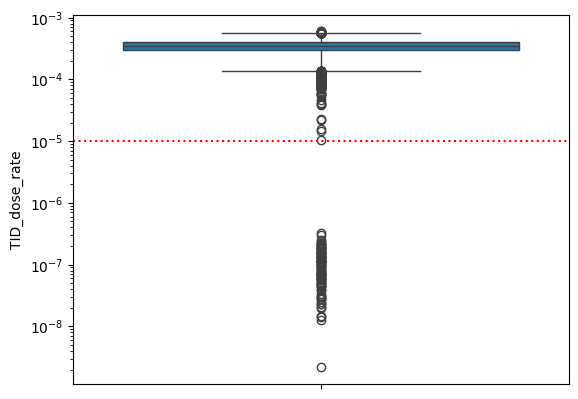

In [6]:
# sin embargo viendo que hay una poblacion separada
# espero que aquello sea un indicativo

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Dibujar el boxplot
sns.boxplot(y=df['TID_dose_rate'])

# 2. Escala logarítmica en el eje Y
plt.yscale('log')

# 3. Añadir línea horizontal en y = 1e-6, roja y punteada
plt.axhline(
    y=epsilon,
    color='red',
    linestyle=':',   # ':' es línea punteada
    linewidth=1.5    # grosor de línea
)

# 4. Mostrar la gráfica
plt.show()


In [7]:
df

,Time,TID,HEH,N1MeV,run_group,dt,dTID,dHEH,dN1MeV,TID_dose_rate,N1MeV_dose_rate,HEH_dose_rate,beam_on
0,2022-11-09 11:50:54.109810944,0.000000,0.000000e+00,0.000000e+00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2022-11-09 11:51:45.164716544,0.000005,8.850860e+03,4.336254e+04,1,51.054906,0.000005,8.850860e+03,4.336254e+04,9.196797e-08,9.196797e-08,9.196797e-08,False
2,2022-11-09 11:52:36.219621888,0.000006,1.177762e+04,5.770146e+04,1,51.054905,0.000002,2.926762e+03,1.433892e+04,3.041155e-08,3.041155e-08,3.041155e-08,False
3,2022-11-09 11:53:27.274527488,0.000014,2.672811e+04,1.309476e+05,1,51.054906,0.000008,1.495049e+04,7.324612e+04,1.553483e-07,1.553483e-07,1.553483e-07,False
4,2022-11-09 11:54:18.329433088,0.000024,4.560054e+04,2.234082e+05,1,51.054906,0.000010,1.887242e+04,9.246064e+04,1.961006e-07,1.961006e-07,1.961006e-07,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,2022-11-15 09:33:14.725472512,176.288344,3.323036e+11,1.628037e+12,1,51.054906,0.005045,9.509583e+06,4.658978e+07,9.881266e-05,9.881266e-05,9.881266e-05,True
9993,2022-11-15 09:34:05.780378112,176.298514,3.323227e+11,1.628131e+12,1,51.054906,0.010170,1.916998e+07,9.391841e+07,1.991924e-04,1.991924e-04,1.991924e-04,True
9994,2022-11-15 09:34:56.835283456,176.303623,3.323324e+11,1.628178e+12,1,51.054905,0.005109,9.629917e+06,4.717932e+07,1.000630e-04,1.000630e-04,1.000630e-04,True
9995,2022-11-15 09:35:47.890189056,176.312541,3.323492e+11,1.628260e+12,1,51.054906,0.008919,1.681151e+07,8.236369e+07,1.746858e-04,1.746858e-04,1.746858e-04,True
